<a href="https://colab.research.google.com/github/ntmdrgl/CSCI-164/blob/main/csci_164_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!gdown 1G5PCNURPLO-mxdOWAoBjfhxDRRwzL79t
!gdown 1B3utxcfUEWVoUTCDxAtyvUCoHYV4iEgy

Downloading...
From: https://drive.google.com/uc?id=1G5PCNURPLO-mxdOWAoBjfhxDRRwzL79t
To: /content/student-mat.csv
100% 57.0k/57.0k [00:00<00:00, 5.46MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B3utxcfUEWVoUTCDxAtyvUCoHYV4iEgy
To: /content/letter-recognition.csv
100% 713k/713k [00:00<00:00, 20.0MB/s]


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import itertools

import warnings
warnings.filterwarnings(action = 'ignore')

from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold, GridSearchCV, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn import metrics
from sklearn.inspection import PartialDependenceDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

Student Preprocess

In [28]:
student = pd.read_csv('student-mat.csv', sep=';')

student.isnull().sum()
student.dropna()
student.drop_duplicates()


num_features = [
    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
    'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'
]

cat_features = [
    'school', 'sex', 'address', 'famsize', 'Pstatus',
    'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup',
    'famsup', 'paid', 'activities', 'nursery', 'higher',
    'internet', 'romantic'
]

X_student = student.drop(columns=['G1', 'G2', 'G3'])
y_student = student[['G3']]

X_train, X_test, y_train, y_test = train_test_split(X_student, y_student, test_size=0.1, random_state=123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/(1-0.1), random_state=123)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

KNN Tuning

In [29]:
# Apply 5-fold cross-validation over tuning grid using validation_curve
k = [3, 5, 7, 9, 11, 15, 21, 25, 27, 29, 31, 33, 35, 37, 41, 45, 51]
kf = KFold(n_splits=10, random_state=123, shuffle=True)

param_grid = {'n_neighbors': k}
knnr = KNeighborsRegressor()
knnTuning = GridSearchCV(estimator=knnr, param_grid=param_grid, cv=kf)

X_trainval = np.vstack((X_train, X_val))
y_trainval = np.hstack((np.ravel(y_train), np.ravel(y_val)))
knnTuning.fit(X_trainval, np.ravel(y_trainval))

# Best parameters
print(f"Best parameters: {knnTuning.best_params_}")
print(f"Best cross-validation score: {knnTuning.best_score_:.4f}")

# Mean testing score for each k and best model
print('Mean testing scores:', knnTuning.cv_results_['mean_test_score'])
print('Best estimator:', knnTuning.best_estimator_)

# Evaluate on test set
bestKnnModel = knnTuning.best_estimator_
test_score = bestKnnModel.score(X_test, y_test)
print(f"Test set score: {test_score:.4f}")

Best parameters: {'n_neighbors': 15}
Best cross-validation score: 0.0982
Mean testing scores: [-0.10212711  0.00877167  0.04854867  0.07389426  0.07520124  0.09821669
  0.09337225  0.07924626  0.07094446  0.07591473  0.08063038  0.08176284
  0.07890365  0.08299404  0.08361646  0.08202787  0.07562466]
Best estimator: KNeighborsRegressor(n_neighbors=15)
Test set score: 0.1386


KNN validation

[-1.03251801 -1.02589351 -0.65354897 -0.60075859 -0.75957698 -0.63504387
 -0.75312152 -0.63804399 -0.68762068 -0.7598571  -0.78887324 -0.75262929
 -0.73313541         nan         nan         nan         nan]


Text(0, 0.5, 'Score')

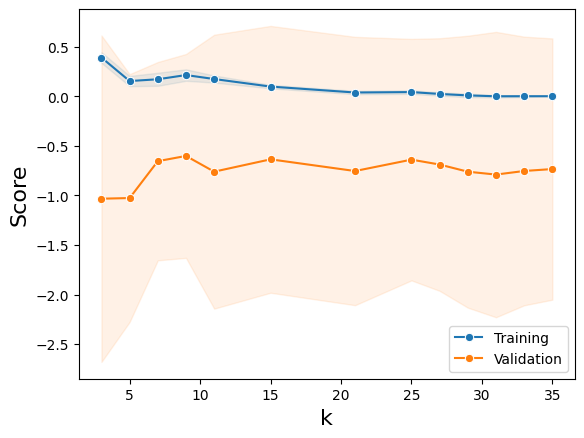

In [30]:
train_scores, test_scores = validation_curve(KNeighborsRegressor(), X_val, np.ravel(y_val), param_range=k, param_name='n_neighbors', cv=kf)

# Calculate mean and SD for training and testing
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print(test_scores_mean)

# Plot cross-validation results on training/validation for each parameter value
sns.lineplot(x=k, y=train_scores_mean, label='Training', color='#1f77b4', marker='o')
sns.lineplot(x=k, y=test_scores_mean, label='Validation', color='#ff7f0e', marker='o')
plt.fill_between(k, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,
                 alpha=0.1, color='#1f77b4')
plt.fill_between(k, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std,
                 alpha=0.1, color='#ff7f0e')

plt.xlabel('k', fontsize=16)
plt.ylabel('Score', fontsize=16)

ENet Tuning

In [31]:
alphas = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

param_grid = {
    'alpha': alphas,
    'l1_ratio': l1_ratios
}

kf = KFold(n_splits=10, random_state=123, shuffle=True)

elastic_net = ElasticNet(max_iter=10000)
eNetTuning = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=kf, scoring='r2', verbose=1)

X_trainval = np.vstack((X_train, X_val))
y_trainval = np.hstack((np.ravel(y_train), np.ravel(y_val)))
eNetTuning.fit(X_trainval, np.ravel(y_trainval))

# Best parameters
print(f"Best parameters: {eNetTuning.best_params_}")
print(f"Best cross-validation score: {eNetTuning.best_score_:.4f}")

# Mean testing score for each k and best model
print('Mean testing scores:', eNetTuning.cv_results_['mean_test_score'])
print('Best estimator:', eNetTuning.best_estimator_)

# Evaluate on test set
bestENetModel = eNetTuning.best_estimator_
test_score = bestENetModel.score(X_test, y_test)
print(f"Test set score: {test_score:.4f}")

Fitting 10 folds for each of 42 candidates, totalling 420 fits
Best parameters: {'alpha': 0.5, 'l1_ratio': 0.1}
Best cross-validation score: 0.0994
Mean testing scores: [ 0.0078654   0.00792557  0.00797314  0.00794618  0.00781548  0.00776115
  0.02179369  0.02229605  0.0225295   0.02174246  0.02016835  0.01938329
  0.07685959  0.07835336  0.08081598  0.08096716  0.08028851  0.07944858
  0.09943504  0.08521346  0.08213846  0.07704033  0.07162399  0.07091459
  0.08067055  0.06693767  0.05447546  0.04730899  0.04187749  0.03798606
  0.00353365 -0.02632403 -0.02975425 -0.02975425 -0.02975425 -0.02975425
 -0.02096403 -0.02975425 -0.02975425 -0.02975425 -0.02975425 -0.02975425]
Best estimator: ElasticNet(alpha=0.5, l1_ratio=0.1, max_iter=10000)
Test set score: 0.2151


ENet validation

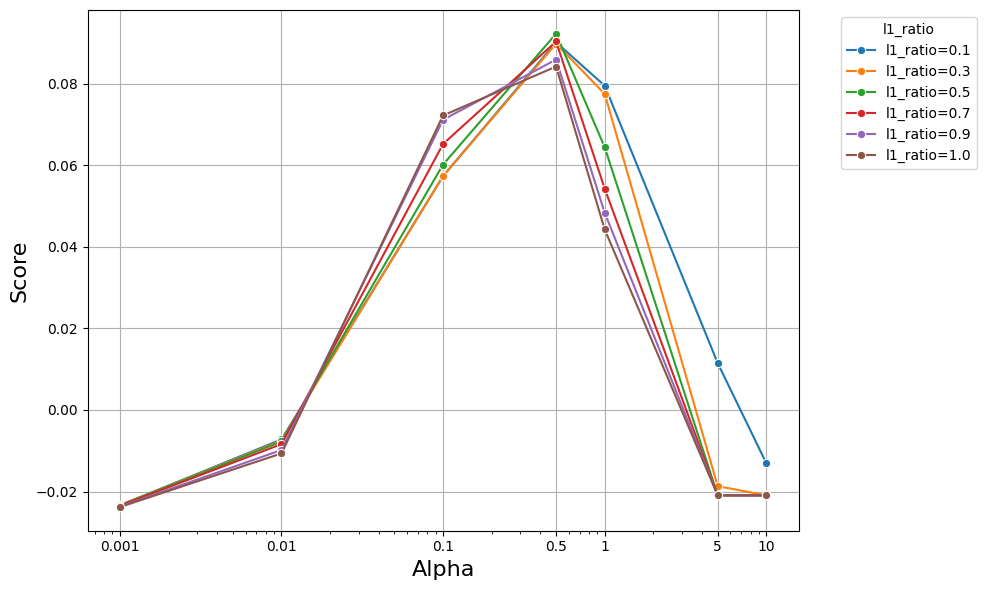

In [32]:
# Set up plot
plt.figure(figsize=(10, 6))

# For each l1_ratio, plot a validation curve across alphas
for l1 in l1_ratios:
    elastic_net = ElasticNet(l1_ratio=l1, max_iter=10000)

    train_scores, test_scores = validation_curve(
        elastic_net, X_train, np.ravel(y_train),
        param_name='alpha', param_range=alphas, cv=kf
    )

    # Mean and std of scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot only validation mean scores (for readability)
    sns.lineplot(x=alphas, y=test_scores_mean, label=f'l1_ratio={l1}', marker='o')

# Plot settings
plt.xscale('log')  # alpha is better viewed on log scale
plt.xticks(alphas, labels=[str(a) for a in alphas])  # <-- Format x-ticks nicely
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.legend(title='l1_ratio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Regression Scores

In [33]:
cv_results = cross_validate(knnTuning, X_train, np.ravel(y_train), cv=kf)
knnScores = cv_results['test_score']
print('k-nearest neighbor scores:', knnScores.round(3))
print('Mean:', knnScores.mean().round(3))
print('SD:', knnScores.std().round(3))

test_score = bestKnnModel.score(X_test, y_test)
print(f"Final test set score: {test_score:.4f}")

cv_results = cross_validate(eNetTuning, X_train, np.ravel(y_train), cv=kf)
eNetScore = cv_results['test_score']
print('k-nearest neighbor scores:', eNetScore.round(3))
print('Mean:', eNetScore.mean().round(3))
print('SD:', eNetScore.std().round(3))

test_score = bestENetModel.score(X_test, y_test)
print(f"Final test set score: {test_score:.4f}")


k-nearest neighbor scores: [ 0.08  -0.042  0.082  0.159 -0.068  0.049  0.117  0.135  0.115  0.035]
Mean: 0.066
SD: 0.071
Final test set score: 0.1386
Fitting 10 folds for each of 42 candidates, totalling 420 fits
Fitting 10 folds for each of 42 candidates, totalling 420 fits
Fitting 10 folds for each of 42 candidates, totalling 420 fits
Fitting 10 folds for each of 42 candidates, totalling 420 fits
Fitting 10 folds for each of 42 candidates, totalling 420 fits
Fitting 10 folds for each of 42 candidates, totalling 420 fits
Fitting 10 folds for each of 42 candidates, totalling 420 fits
Fitting 10 folds for each of 42 candidates, totalling 420 fits
Fitting 10 folds for each of 42 candidates, totalling 420 fits
Fitting 10 folds for each of 42 candidates, totalling 420 fits
k-nearest neighbor scores: [0.131 0.082 0.088 0.073 0.013 0.009 0.047 0.187 0.031 0.106]
Mean: 0.077
SD: 0.053
Final test set score: 0.2151


Regression Model Evaluation

KNN MAE: 3.343
KNN MSE: 19.204
KNN RMSE: 4.382
KNN R-squared: 0.139


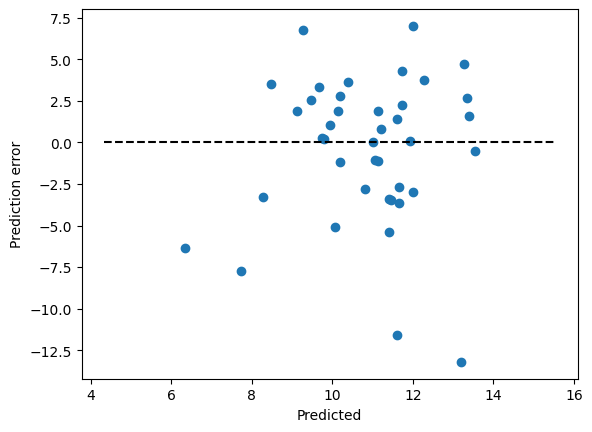

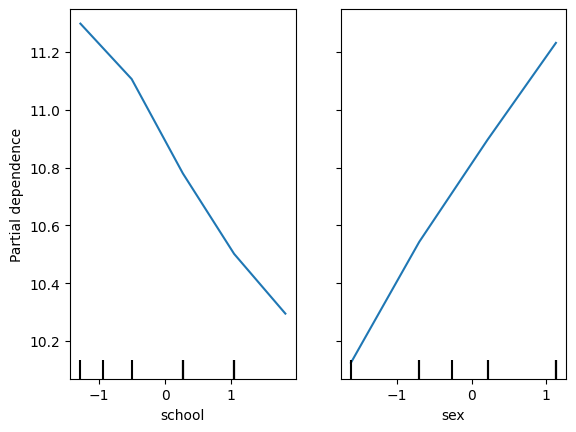

In [34]:
knn_preds = bestKnnModel.predict(X_test)

mae = metrics.mean_absolute_error(y_test, knn_preds)
print("KNN MAE:", round(mae, 3))

mse = metrics.mean_squared_error(y_test, knn_preds)
print("KNN MSE:", round(mse, 3))

rmse = rmse = np.sqrt(mse)
print("KNN RMSE:", round(rmse, 3))

r2 = metrics.r2_score(y_test, knn_preds)
print("KNN R-squared:", round(r2, 3))

KNPredError = np.ravel(y_test) - knn_preds

fig = plt.figure()
plt.scatter(knn_preds, KNPredError)
plt.xlabel('Predicted')
plt.ylabel('Prediction error')

plt.plot([min(knn_preds)-2, max(knn_preds)+2], [0,0], linestyle='dashed', color='black')
plt.show()

feature_names = X_student.columns.tolist()
top_n_features = feature_names[:2]
PartialDependenceDisplay.from_estimator(bestKnnModel, X_test, features=top_n_features, feature_names=top_n_features)
plt.show()

KNN MAE: 3.209
KNN MSE: 17.498
KNN RMSE: 4.183
KNN R-squared: 0.215


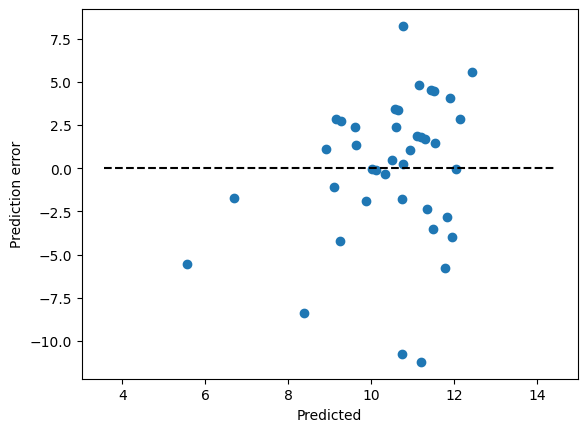

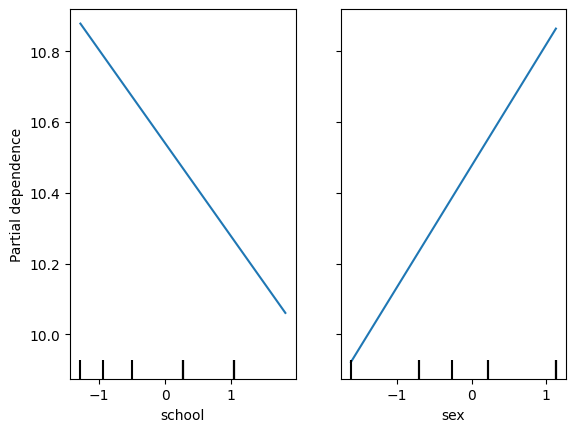

In [35]:
enet_preds = bestENetModel.predict(X_test)

mae = metrics.mean_absolute_error(y_test, enet_preds)
print("KNN MAE:", round(mae, 3))

mse = metrics.mean_squared_error(y_test, enet_preds)
print("KNN MSE:", round(mse, 3))

rmse = rmse = np.sqrt(mse)
print("KNN RMSE:", round(rmse, 3))

r2 = metrics.r2_score(y_test, enet_preds)
print("KNN R-squared:", round(r2, 3))

ENetPredError = np.ravel(y_test) - enet_preds

fig = plt.figure()
plt.scatter(enet_preds, ENetPredError)
plt.xlabel('Predicted')
plt.ylabel('Prediction error')

plt.plot([min(enet_preds)-2, max(enet_preds)+2], [0,0], linestyle='dashed', color='black')
plt.show()

feature_names = X_student.columns.tolist()
top_n_features = feature_names[:2]
PartialDependenceDisplay.from_estimator(bestENetModel, X_test, features=top_n_features, feature_names=top_n_features)
plt.show()

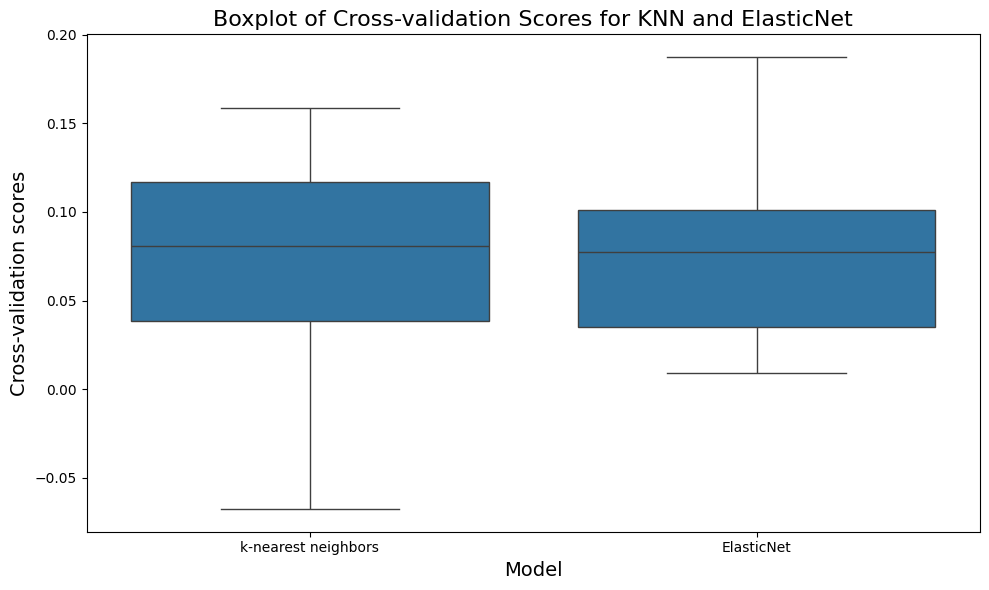

In [36]:
# Combine scores from both models into a dataframe
df = pd.DataFrame({'knn': knnScores, 'enet': eNetScore})

df_combined = pd.DataFrame({
    'Model': ['k-nearest neighbors'] * len(df['knn']) + ['ElasticNet'] * len(df['enet']),
    'Cross-validation scores': list(df['knn']) + list(df['enet'])
})

# Create the boxplot for both models on the same plot
plt.figure(figsize=(10, 6))
p = sns.boxplot(x='Model', y='Cross-validation scores', data=df_combined)
p.set_xlabel('Model', fontsize=14)
p.set_ylabel('Cross-validation scores', fontsize=14)
plt.title('Boxplot of Cross-validation Scores for KNN and ElasticNet', fontsize=16)
plt.tight_layout()
plt.show()

Letter Recognition

In [37]:
letter = pd.read_csv('letter-recognition.csv')

# data pre-processing
letter.isnull().sum()
letter.dropna()
letter.drop_duplicates()

# define attributes
X = letter.drop(columns=['lettr'])
y = letter[['lettr']]

# 80% train, 10% validation, 10% testing
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1/(1-0.1), random_state=123)

# feature-transformation
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_val = standard_scaler.transform(X_val)
X_test = standard_scaler.transform(X_test)

Letter Recognition: K-nearest neighbors

Text(0, 0.5, 'Score')

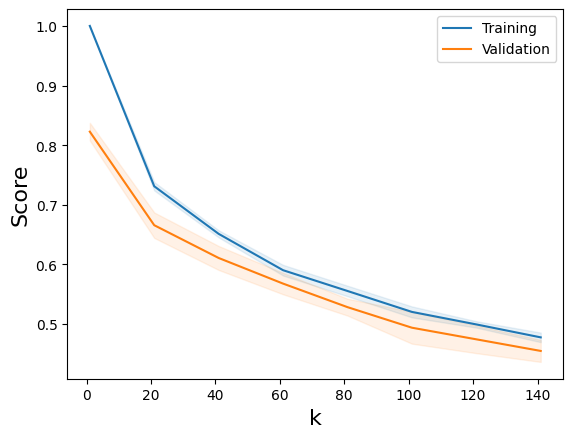

In [38]:
# Apply kfold cross-validation over tuning grid using validation_curve
k = [1, 21, 41, 61, 81, 101, 121, 141]
kf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_val, np.ravel(y_val), param_range=k, param_name='n_neighbors', cv=kf)

# Calculate mean and SD for training and testing
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot cross-validation results on training/validation for each parameter value
sns.lineplot(x=k, y=train_scores_mean, label='Training', color='#1f77b4')
sns.lineplot(x=k, y=test_scores_mean, label='Validation', color='#ff7f0e')
plt.fill_between(k, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,
                 alpha=0.1, color='#1f77b4')
plt.fill_between(k, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std,
                 alpha=0.1, color='#ff7f0e')

plt.xlabel('k', fontsize=16)
plt.ylabel('Score', fontsize=16)

In [39]:
# combine training and validation sets
X_trainval = np.vstack((X_train, X_val))
y_trainval = np.hstack((np.ravel(y_train), np.ravel(y_val)))

# fit knn model using best k combining training and validation sets
best_k = k[np.argmax(test_scores_mean)]
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_trainval, y_trainval)

# cross-validation on combined training and validation sets
cv_results = cross_validate(knn_model, X_trainval, np.ravel(y_trainval), cv=5)
cv_scores = cv_results['test_score']
print('Cross-validation scores:', cv_scores.round(3))
print('  Mean:', cv_scores.mean().round(3))
print('  SD:', cv_scores.std().round(3))

# evaluate model on testing set
test_score = knn_model.score(X_test, y_test)
print(f"Final score on testing set with k={best_k}: {test_score:.4f}")

Cross-validation scores: [0.95  0.948 0.947 0.947 0.951]
  Mean: 0.949
  SD: 0.002
Final score on testing set with k=1: 0.9570


Letter Recognition: Gaussian Naive Bayes

In [40]:
# fit gaussianNB model on combined training and validation sets
gnb_model = GaussianNB()
gnb_model.fit(X_trainval, y_trainval)

# cross-validation on combined training and validation sets
cv_results = cross_validate(gnb_model, X_trainval, np.ravel(y_trainval), cv=5)
cv_scores = cv_results['test_score']
print('Cross-validation scores:', cv_scores.round(3))
print('  Mean:', cv_scores.mean().round(3))
print('  SD:', cv_scores.std().round(3))

# evaluate model on testing set
test_score = gnb_model.score(X_test, y_test)
print(f"Final score on testing set: {test_score:.4f}")

Cross-validation scores: [0.647 0.632 0.636 0.646 0.661]
  Mean: 0.644
  SD: 0.01
Final score on testing set: 0.6320


Letter Recognition: Quadratic Discriminant Analysis

In [41]:
# fit quadratic discriminant model on combined training and validation sets
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_trainval, y_trainval)

# cross-validation on combined training and validation sets
cv_results = cross_validate(qda_model, X_trainval, np.ravel(y_trainval), cv=5)
cv_scores = cv_results['test_score']
print('Cross-validation scores:', cv_scores.round(3))
print('  Mean:', cv_scores.mean().round(3))
print('  SD:', cv_scores.std().round(3))

# evaluate model on testing set
test_score = qda_model.score(X_test, y_test)
print(f"Final score on testing set: {test_score:.4f}")

Cross-validation scores: [0.891 0.885 0.881 0.879 0.892]
  Mean: 0.885
  SD: 0.005
Final score on testing set: 0.8780


Letter Recognition: Model Evaluation

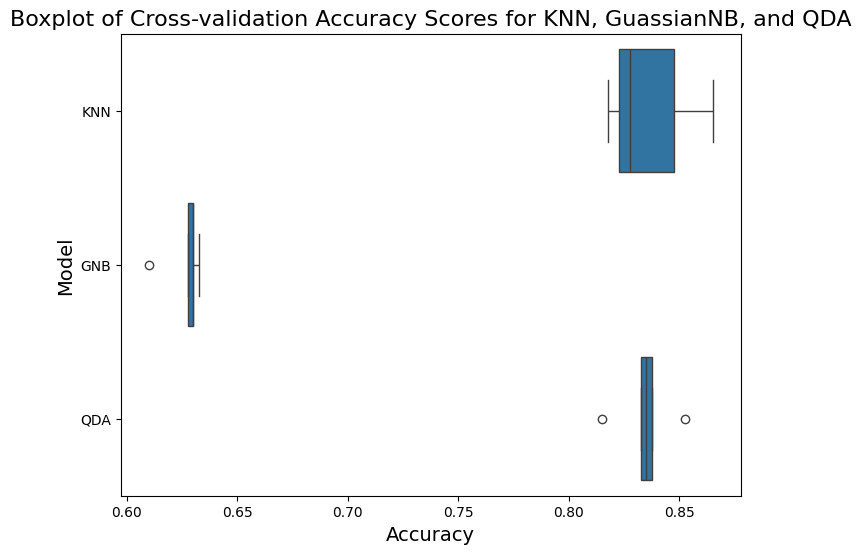

In [42]:
# Evaluate each model with cross-validation using accuracy scores
cv_knn = cross_val_score(knn_model, X_test, y_test, cv=5, scoring='accuracy')
cv_gnb = cross_val_score(gnb_model, X_test, y_test, cv=5, scoring='accuracy')
cv_qda = cross_val_score(qda_model, X_test, y_test, cv=5, scoring='accuracy')

import pandas as pd
cv_results = pd.DataFrame({
    'KNN': cv_knn,
    'GNB': cv_gnb,
    'QDA': cv_qda
})

cv_results = pd.DataFrame({
    'Accuracy': list(cv_knn) + list(cv_gnb) + list(cv_qda),
    'Model': ['KNN'] * len(cv_knn) + ['GNB'] * len(cv_gnb) + ['QDA'] * len(cv_qda)
})
plt.figure(figsize=(8, 6))
sns.boxplot(x='Accuracy', y='Model', data=cv_results)

plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.title('Boxplot of Cross-validation Accuracy Scores for KNN, GuassianNB, and QDA', fontsize=16)

plt.show()

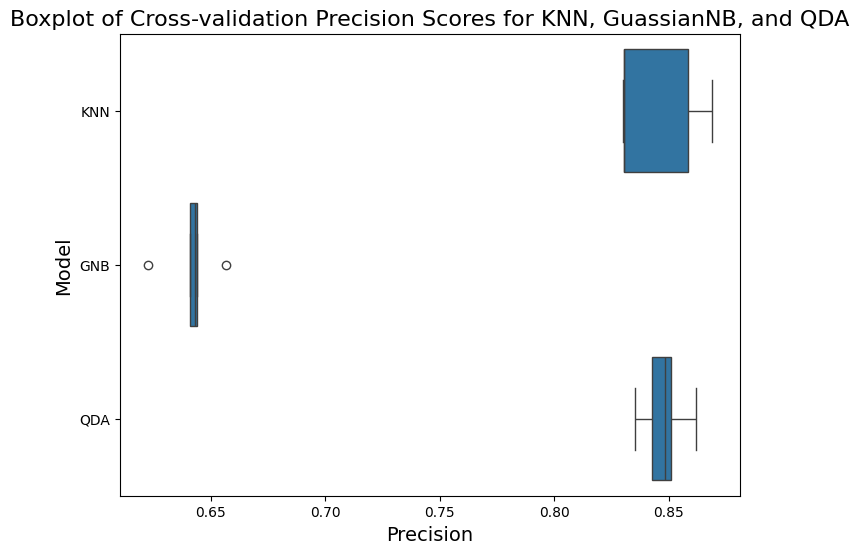

In [43]:
# Evaluate each model with cross-validation using precision scores
cv_knn = cross_val_score(knn_model, X_test, y_test, cv=5, scoring='precision_macro')
cv_gnb = cross_val_score(gnb_model, X_test, y_test, cv=5, scoring='precision_macro')
cv_qda = cross_val_score(qda_model, X_test, y_test, cv=5, scoring='precision_macro')

cv_results = pd.DataFrame({
    'Precision': list(cv_knn) + list(cv_gnb) + list(cv_qda),
    'Model': ['KNN'] * len(cv_knn) + ['GNB'] * len(cv_gnb) + ['QDA'] * len(cv_qda)
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Precision', y='Model', data=cv_results)

plt.xlabel('Precision', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.title('Boxplot of Cross-validation Precision Scores for KNN, GuassianNB, and QDA', fontsize=16)

plt.show()